In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:11<00:00, 97.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Paths
source_folder = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
destination_folder ="test_images"
images_per_class = 50  # Number of images to copy per class

# Create the destination folder
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create a corresponding folder in the destination
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)

        # Get all image files in the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Sort images to maintain order and select the first 50
        selected_images = images[:images_per_class]

        # Copy selected images to the destination folder
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(dest_class_folder, img_name)
            shutil.copy(src, dest)

print(f"Test dataset created successfully in '{destination_folder}'")


Test dataset created successfully in 'test_images'


In [3]:
train_path = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/'
test_path  = "test_images"

!du --inodes '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/'
!du --inodes "test_images"

import glob
from pathlib import Path

for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

1739	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/blast
338	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_panicle_blight
966	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/brown_spot
1089	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/tungro
1765	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/normal
1443	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/dead_heart
381	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_streak
1595	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/hispa
480	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_blight
621	/root/.cache/kagglehub/datasets/ricar

In [4]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [5]:
import os
from keras.models import Model
#from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

#https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)

#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))


    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    lr=3e-4
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

#plot_model(model, '/kaggle/working/model.png', show_shapes=True)

channels_last


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [7]:
input_shape = (256, 256, 3)

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg16_model = create_model(input_shape, n_classes, optim_2, fine_tune=2)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 500 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
500


In [9]:

!pip install livelossplot

In [10]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='vgg_model_ft.best.keras',
                                  save_best_only=True,
                                  verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

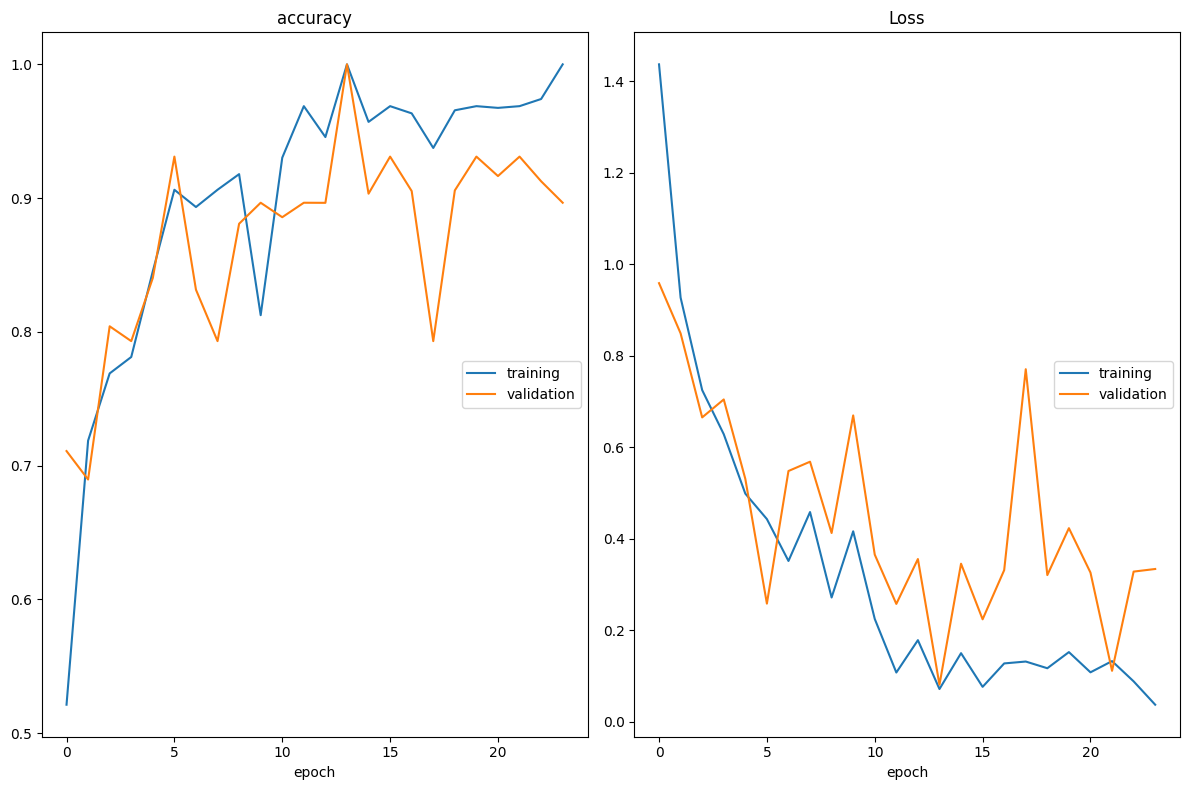

accuracy
	training         	 (min:    0.521, max:    1.000, cur:    1.000)
	validation       	 (min:    0.690, max:    1.000, cur:    0.897)
Loss
	training         	 (min:    0.037, max:    1.436, cur:    0.037)
	validation       	 (min:    0.081, max:    0.958, cur:    0.334)
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0372 - val_accuracy: 0.8966 - val_loss: 0.3338
CPU times: user 45min 30s, sys: 41.5 s, total: 46min 12s
Wall time: 40min 24s


In [11]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
vgg16_history = vgg16_model.fit(train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

In [12]:
test_path_new = "/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/"
!du --inodes "/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/"

for filepath in glob.glob(test_path_new + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

1739	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/blast
338	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_panicle_blight
966	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/brown_spot
1089	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/tungro
1765	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/normal
1443	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/dead_heart
381	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_streak
1595	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/hispa
480	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_blight
621	/root/.cache/kagglehub/datasets/ricar

In [13]:
class_subset = sorted(os.listdir(test_path_new))#[:10] # Using only the first 10 classes
class_subset

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [14]:
test_generator_vgg = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path_new,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=class_subset,
    class_mode=None,
    shuffle=False,
    seed=SEED)

vgg16_model.load_weights('vgg_model_ft.best.keras') # initialize the best trained weights
# vgg16_model.load_weights('../input/pd2vgg16weightsbest/vgg_model_ft.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg16_model.predict(test_generator_vgg)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

Found 10407 images belonging to 10 classes.
10407/10407 ━━━━━━━━━━━━━━━━━━━━ 102s 9ms/step


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator_vgg.class_indices.keys()

true_classes = test_generator_vgg.classes

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

cls_report = classification_report(true_classes, vgg_pred_classes_ft,
                                   target_names=class_names, digits=5)
print(cls_report)

VGG16 Model Accuracy with Fine-Tuning: 96.31%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.96937   0.92484   0.94658       479
   bacterial_leaf_streak    0.99143   0.91316   0.95068       380
bacterial_panicle_blight    0.99679   0.92285   0.95840       337
                   blast    0.98107   0.95397   0.96733      1738
              brown_spot    0.90508   0.97824   0.94024       965
              dead_heart    0.97145   0.99098   0.98112      1442
            downy_mildew    0.94006   0.96129   0.95056       620
                   hispa    0.98008   0.95671   0.96825      1594
                  normal    0.97708   0.96655   0.97179      1764
                  tungro    0.92689   0.97886   0.95217      1088

                accuracy                        0.96310     10407
               macro avg    0.96393   0.95475   0.95871     10407
            weighted avg    0.96410   0.96310   0.96319     10407



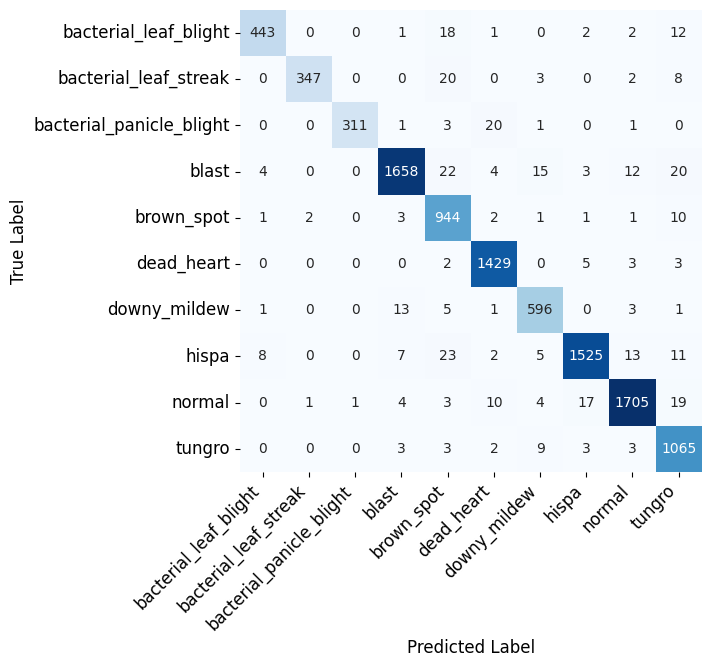

[[ 443    0    0    1   18    1    0    2    2   12]
 [   0  347    0    0   20    0    3    0    2    8]
 [   0    0  311    1    3   20    1    0    1    0]
 [   4    0    0 1658   22    4   15    3   12   20]
 [   1    2    0    3  944    2    1    1    1   10]
 [   0    0    0    0    2 1429    0    5    3    3]
 [   1    0    0   13    5    1  596    0    3    1]
 [   8    0    0    7   23    2    5 1525   13   11]
 [   0    1    1    4    3   10    4   17 1705   19]
 [   0    0    0    3    3    2    9    3    3 1065]]


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator_vgg.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax, title="VGG16")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, vgg_pred_classes_ft)
print(cm)

In [18]:
# %%time
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
# history = model.fit_generator(generator = train_generator,
#                     steps_per_epoch = STEP_SIZE_TRAIN,
#                     validation_data = valid_generator,
#                     validation_steps = STEP_SIZE_VALID,
#                     epochs=EPOCHS)

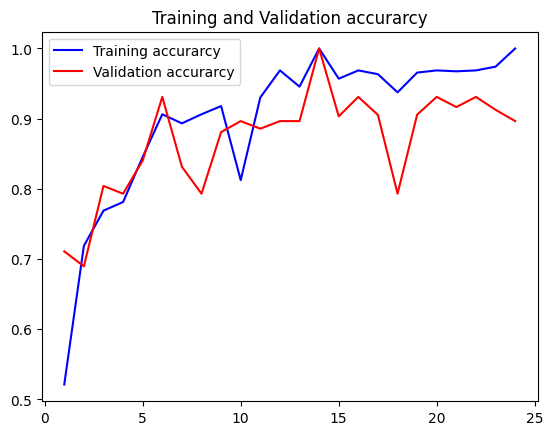

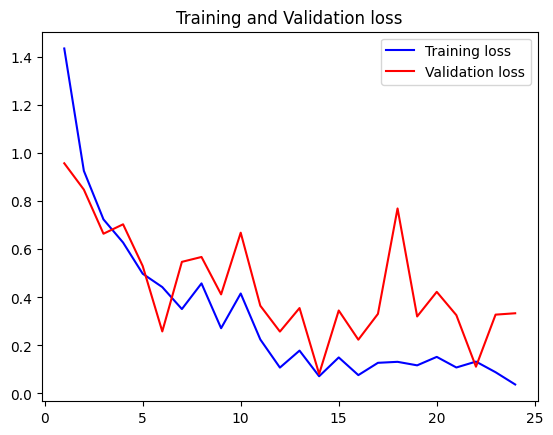

CPU times: user 421 ms, sys: 210 ms, total: 631 ms
Wall time: 409 ms


In [19]:
%%time
history = vgg16_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
pred = vgg16_model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

 13/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


In [21]:
# print(test_generator.samples)

In [22]:
# x = next(test_generator)
# print("Batch X shape:", x.shape)
# print("Batch Y shape:", y.shape)


In [24]:
# Recalculate steps
STEP_SIZE_TEST = max(1, test_generator.n // test_generator.batch_size)

# Evaluate the model
loss, acc = vgg16_model.evaluate(
    valid_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

print(f"Test Accuracy: {acc}")
print(f"Test Loss: {loss}")


500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8953 - loss: 0.3668  


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Accuracy: 0.89552241563797
Test Loss: 0.36671772599220276


In [25]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
brown_spot,56
dead_heart,53
normal,52
tungro,51
downy_mildew,51
blast,50
hispa,48
bacterial_leaf_blight,47
bacterial_panicle_blight,47
bacterial_leaf_streak,45


In [26]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100582.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100681.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100956.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/101394.jpg,tungro
4,bacterial_leaf_blight/101485.jpg,hispa
